## VGG for Emotion Detection

In [1]:
import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization
from keras.layers import Conv2D, MaxPooling2D
from keras.preprocessing.image import ImageDataGenerator
import os
from keras.models import Sequential
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.layers.advanced_activations import ELU
from keras.layers.core import Activation, Flatten, Dropout, Dense
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from keras.models import load_model
from keras.preprocessing import image
from time import sleep
from keras.preprocessing.image import img_to_array
import numpy as np
import os
import cv2
from os import listdir
from os.path import isfile, join
import re
import matplotlib.pyplot as plt
import sklearn
from sklearn.metrics import classification_report, confusion_matrix
from keras.utils.vis_utils import plot_model
import matplotlib.image as mpimg
%matplotlib inline

Using TensorFlow backend.


In [2]:
num_classes = 7
img_rows, img_cols = 48, 48
batch_size = 16

In [3]:
train_data_dir = 'fer2013/train'
validation_data_dir = 'fer2013/validation'

In [4]:
train_datagen = ImageDataGenerator(
      rescale=1./255,
      rotation_range=30,
      shear_range=0.3,
      zoom_range=0.3,
      width_shift_range=0.4,
      height_shift_range=0.4,
      horizontal_flip=True,
      fill_mode='nearest')

In [5]:
validation_datagen = ImageDataGenerator(rescale=1./255)

In [6]:
train_generator = train_datagen.flow_from_directory(
        train_data_dir,
        color_mode = 'grayscale',
        target_size=(img_rows, img_cols),
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=True)

Found 28709 images belonging to 7 classes.


In [7]:
validation_generator = validation_datagen.flow_from_directory(
        validation_data_dir,
        color_mode = 'grayscale',
        target_size=(img_rows, img_cols),
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=True)

Found 3589 images belonging to 7 classes.


## VGG Model

In [8]:
def vgg():
    model = Sequential([
    Conv2D(32, (3, 3), padding = 'same', kernel_initializer="he_normal",input_shape = (img_rows, img_cols, 1)),
    Activation('elu'),
    BatchNormalization(),
    Conv2D(32, (3, 3), padding = "same", kernel_initializer="he_normal", 
                     input_shape = (img_rows, img_cols, 1)),
    Activation('elu'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.2),

    # Block #2: second CONV => RELU => CONV => RELU => POOL
    # layer se,
    Conv2D(64, (3, 3), padding="same", kernel_initializer="he_normal"),
    Activation('elu'),
    BatchNormalization(),
    Conv2D(64, (3, 3), padding="same", kernel_initializer="he_normal"),
    Activation('elu'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.2),

    # Block #3: third CONV => RELU => CONV => RELU => POOL
    # layer se,
    Conv2D(128, (3, 3), padding="same", kernel_initializer="he_normal"),
    Activation('elu'),
    BatchNormalization(),
    Conv2D(128, (3, 3), padding="same", kernel_initializer="he_normal"),
    Activation('elu'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.2),
        
    # Block #4: third CONV => RELU => CONV => RELU => POOL
    # layer se,
    Conv2D(256, (3, 3), padding="same", kernel_initializer="he_normal"),
    Activation('elu'),
    BatchNormalization(),
    Conv2D(256, (3, 3), padding="same", kernel_initializer="he_normal"),
    Activation('elu'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.2),

    # Block #5: first set of FC => RELU layer,
    Flatten(),
    Dense(64, kernel_initializer="he_normal"),
    Activation('elu'),
    BatchNormalization(),
    Dropout(0.5),

    # Block #6: second set of FC => RELU layer,
    Dense(64, kernel_initializer="he_normal"),
    Activation('elu'),
    BatchNormalization(),
    Dropout(0.5),

    # Block #7: softmax classifie,
    Dense(num_classes, kernel_initializer="he_normal"),
    Activation("softmax")
    ])
    return model

In [9]:
model = vgg()
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 48, 48, 32)        320       
_________________________________________________________________
activation_1 (Activation)    (None, 48, 48, 32)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 48, 48, 32)        128       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 48, 48, 32)        9248      
_________________________________________________________________
activation_2 (Activation)    (None, 48, 48, 32)        0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 48, 48, 32)        128       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 24, 24, 32)        0         
__________

## Training VGG model

In [10]:
checkpoint = ModelCheckpoint("emotion_vgg_1.h5",
                             monitor="val_loss",
                             mode="min",
                             save_best_only = True,
                             verbose=1)

earlystop = EarlyStopping(monitor = 'val_loss', 
                          min_delta = 0, 
                          patience = 3,
                          verbose = 1,
                          restore_best_weights = True)

reduce_lr = ReduceLROnPlateau(monitor = 'val_loss', factor = 0.2, patience = 3, verbose = 1, min_delta = 0.0001)

callbacks = [earlystop, checkpoint, reduce_lr]

In [11]:
model.compile(loss = 'categorical_crossentropy',
              optimizer = Adam(lr=0.001),
              metrics = ['accuracy'])

In [12]:
nb_train_samples = 28273
nb_validation_samples = 3589
epochs = 25

In [13]:
history = model.fit_generator(
    train_generator,
    steps_per_epoch = nb_train_samples // batch_size,
    epochs = epochs,
    callbacks = callbacks,
    validation_data = validation_generator,
    validation_steps = nb_validation_samples // batch_size)

Epoch 1/25
1767/1767 [==============================] - 115s 65ms/step - loss: 2.0498 - acc: 0.2030 - val_loss: 1.8007 - val_acc: 0.2400

Epoch 00001: val_loss improved from inf to 1.80070, saving model to emotion_vgg_1.h5
Epoch 2/25
1767/1767 [==============================] - 108s 61ms/step - loss: 1.8037 - acc: 0.2466 - val_loss: 1.7946 - val_acc: 0.2558

Epoch 00002: val_loss improved from 1.80070 to 1.79465, saving model to emotion_vgg_1.h5
Epoch 3/25
1767/1767 [==============================] - 109s 62ms/step - loss: 1.7885 - acc: 0.2552 - val_loss: 1.7439 - val_acc: 0.2844

Epoch 00003: val_loss improved from 1.79465 to 1.74389, saving model to emotion_vgg_1.h5
Epoch 4/25
1767/1767 [==============================] - 108s 61ms/step - loss: 1.7656 - acc: 0.2696 - val_loss: 1.7082 - val_acc: 0.3087

Epoch 00004: val_loss improved from 1.74389 to 1.70823, saving model to emotion_vgg_1.h5
Epoch 5/25
1767/1767 [==============================] - 108s 61ms/step - loss: 1.7123 - acc: 0.2

In [14]:
scores = model.evaluate_generator(validation_generator,steps=nb_validation_samples // batch_size+1, verbose=1)
print('\nTest result: %.3f loss: %.3f' %(scores[1]*100,scores[0]))

225/225 [==============================] - 4s 16ms/step

Test result: 47.868 loss: 1.454


In [15]:
model.save("emotion_vgg.h5")

## Confusion Matrix

In [16]:
validation_generator = validation_datagen.flow_from_directory(
        validation_data_dir,
        color_mode = 'grayscale',
        target_size=(img_rows, img_cols),
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=False)

Found 3589 images belonging to 7 classes.


In [17]:
class_labels = validation_generator.class_indices
class_labels = {v: k for k, v in class_labels.items()}
classes = list(class_labels.values())

In [18]:
y_pred = model.predict_generator(validation_generator, nb_validation_samples // batch_size+1)

In [19]:
y_pred_label = np.argmax(y_pred, axis=1)

In [20]:
#Confusion Matrix and Classification Report
print('Confusion Matrix')
print(confusion_matrix(validation_generator.classes, y_pred_label))
print('Classification Report')
print(classification_report(validation_generator.classes, y_pred_label, target_names=classes))

Confusion Matrix
[[184   0  27  33  93 143  11]
 [ 29   0   5   9   1  11   0]
 [101   0  53  56 129 111  78]
 [ 13   0   2 788  45  20  11]
 [ 83   0  32 174 172 106  59]
 [ 38   0  17  56 231 244   8]
 [ 19   0  23  51  36   6 281]]
Classification Report
              precision    recall  f1-score   support

       Angry       0.39      0.37      0.38       491
     Disgust       0.00      0.00      0.00        55
        Fear       0.33      0.10      0.15       528
       Happy       0.68      0.90      0.77       879
     Neutral       0.24      0.27      0.26       626
         Sad       0.38      0.41      0.40       594
    Surprise       0.63      0.68      0.65       416

   micro avg       0.48      0.48      0.48      3589
   macro avg       0.38      0.39      0.37      3589
weighted avg       0.45      0.48      0.45      3589



D:\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


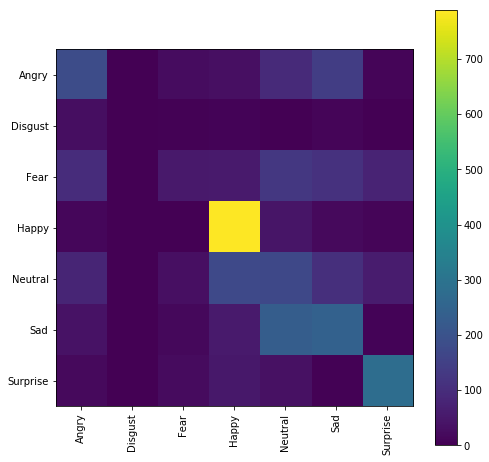

In [21]:
plt.figure(figsize=(8,8))
cnf_matrix = confusion_matrix(validation_generator.classes, y_pred_label)

plt.imshow(cnf_matrix, interpolation='nearest')
plt.colorbar()
tick_marks = np.arange(len(classes))
_ = plt.xticks(tick_marks, classes, rotation=90)
_ = plt.yticks(tick_marks, classes)

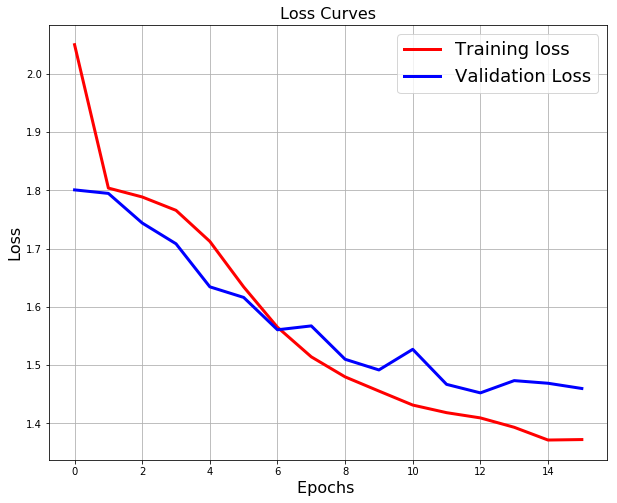

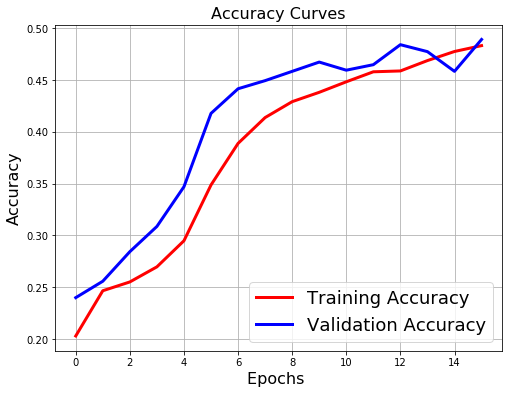

In [22]:
# Loss Curves
plt.figure(figsize=[10,8])
plt.plot(history.history['loss'],'r',linewidth=3.0)
plt.plot(history.history['val_loss'],'b',linewidth=3.0)
plt.legend(['Training loss', 'Validation Loss'],fontsize=18)
plt.grid()
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Loss',fontsize=16)
plt.title('Loss Curves',fontsize=16)
 
# Accuracy Curves
plt.figure(figsize=[8,6])
plt.plot(history.history['acc'],'r',linewidth=3.0)
plt.plot(history.history['val_acc'],'b',linewidth=3.0)
plt.legend(['Training Accuracy', 'Validation Accuracy'],fontsize=18)
plt.grid()
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Accuracy',fontsize=16)
plt.title('Accuracy Curves',fontsize=16);

### Model Plot

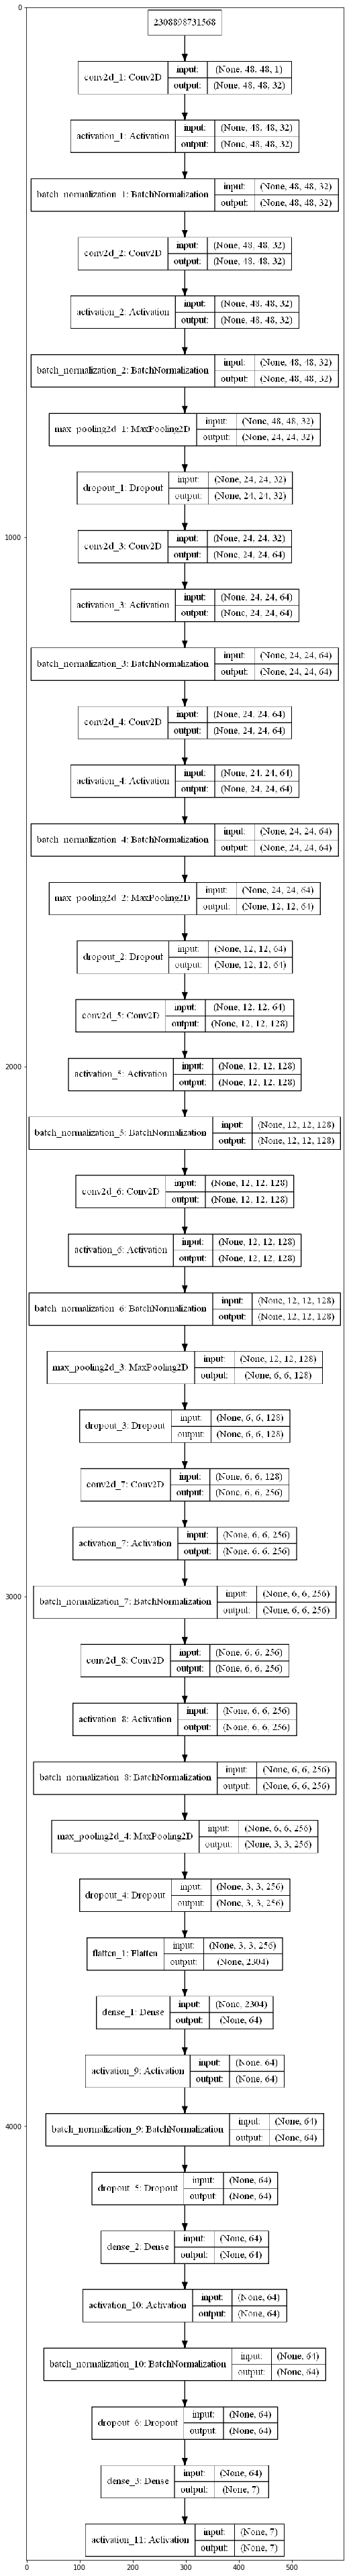

In [23]:
plot_model(model, to_file='Emotion_VGG.png', show_shapes=True, show_layer_names=True)
img = mpimg.imread('Emotion_VGG.png')
plt.figure(figsize=(100,70))
imgplot = plt.imshow(img)

### Loading our saved model

In [24]:
classifier = load_model('emotion_vgg.h5')

### Testing on Images

In [25]:
def draw_test(name, pred, im, true_label):
    BLACK = [0,0,0]
    expanded_image = cv2.copyMakeBorder(im, 160, 0, 0, 300 ,cv2.BORDER_CONSTANT,value=BLACK)
    cv2.putText(expanded_image, "predicted - "+ pred, (20, 60) , cv2.FONT_HERSHEY_SIMPLEX,1, (0,0,255), 2)
    cv2.putText(expanded_image, "true - "+ true_label, (20, 120) , cv2.FONT_HERSHEY_SIMPLEX,1, (0,255,0), 2)
    cv2.imshow(name, expanded_image)


def getRandomImage(path, img_width, img_height):
    """function loads a random images from a random folder in our test path """
    folders = list(filter(lambda x: os.path.isdir(os.path.join(path, x)), os.listdir(path)))
    random_directory = np.random.randint(0,len(folders))
    path_class = folders[random_directory]
    file_path = path + path_class
    file_names = [f for f in listdir(file_path) if isfile(join(file_path, f))]
    random_file_index = np.random.randint(0,len(file_names))
    image_name = file_names[random_file_index]
    final_path = file_path + "/" + image_name
    return image.load_img(final_path, target_size = (img_width, img_height),grayscale=True), final_path, path_class

# dimensions of our images
img_width, img_height = 48, 48

# We use a very small learning rate 
model.compile(loss = 'categorical_crossentropy',
              optimizer = Adam(lr = 0.001),
              metrics = ['accuracy'])

files = []
predictions = []
true_labels = []

# predicting images
for i in range(0, 10):
    path = 'fer2013/validation/' 
    img, final_path, true_label = getRandomImage(path, img_width, img_height)
    files.append(final_path)
    true_labels.append(true_label)
    x = image.img_to_array(img)
    x = x * 1./255
    x = np.expand_dims(x, axis=0)
    images = np.vstack([x])
    classes = model.predict_classes(images, batch_size = 10)
    predictions.append(classes)
    
for i in range(0, len(files)):
    image = cv2.imread((files[i]))
    image = cv2.resize(image, None, fx=3, fy=3, interpolation = cv2.INTER_CUBIC)
    draw_test("Prediction", class_labels[predictions[i][0]], image, true_labels[i])
    cv2.waitKey(0)

cv2.destroyAllWindows()

D:\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '


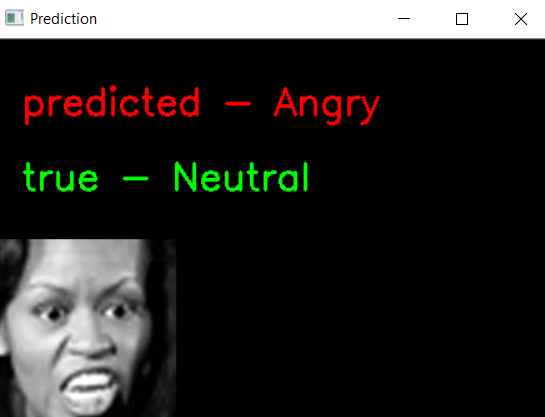

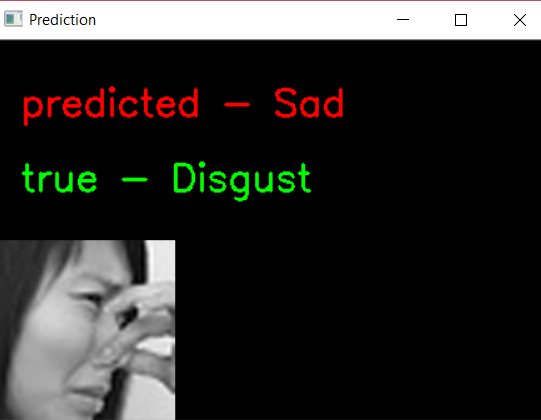

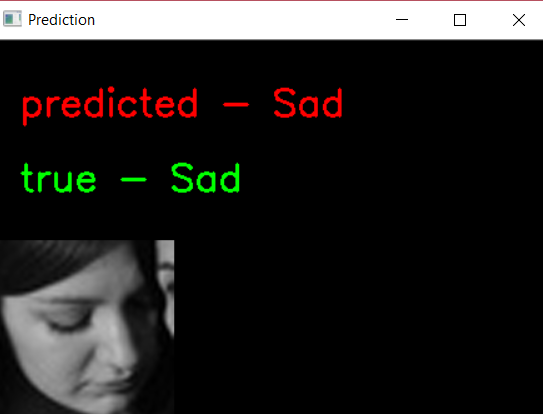

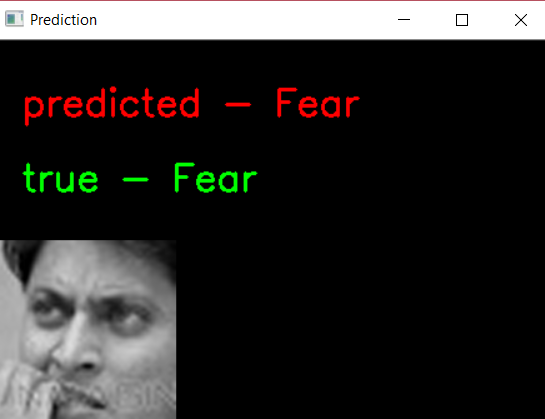

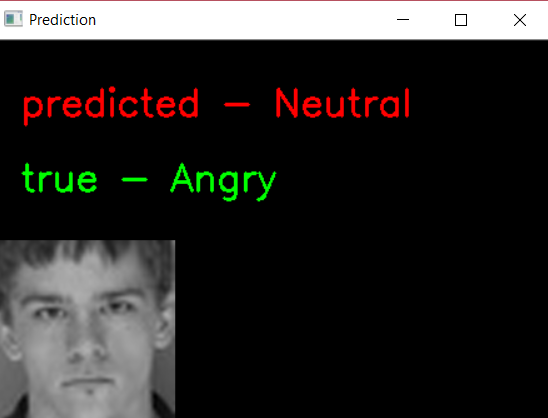

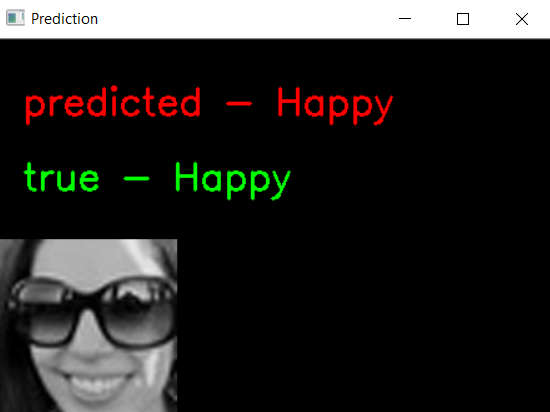

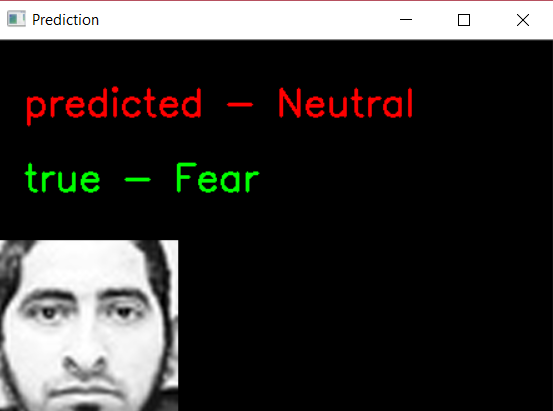

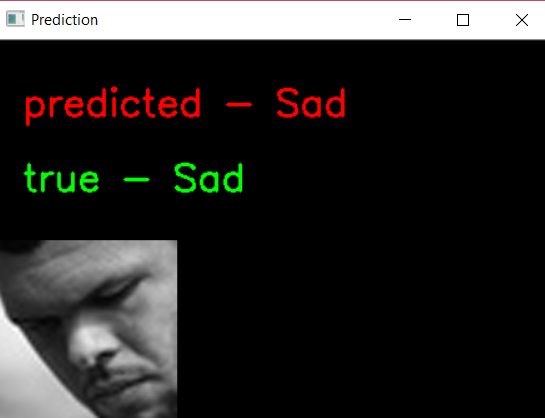

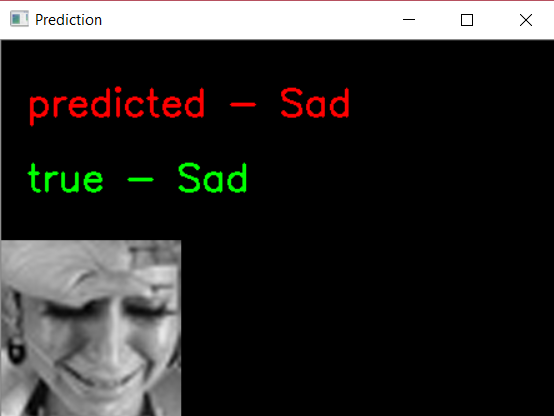

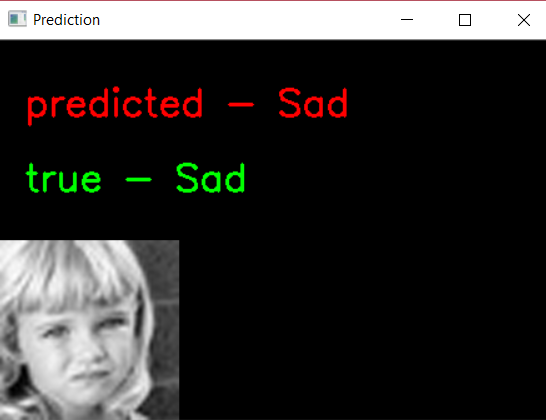

### Testing on single image

In [26]:
face_classifier = cv2.CascadeClassifier('Haarcascades/haarcascade_frontalface_default.xml')

def face_detector(img):
    # Convert image to grayscale
    gray = cv2.cvtColor(img.copy(),cv2.COLOR_BGR2GRAY)
    faces = face_classifier.detectMultiScale(gray, 1.3, 5)
    if faces is ():
        return (0,0,0,0), np.zeros((48,48), np.uint8), img
    
    allfaces = []   
    rects = []
    for (x,y,w,h) in faces:
        cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)
        roi_gray = gray[y:y+h, x:x+w]
        roi_gray = cv2.resize(roi_gray, (48, 48), interpolation = cv2.INTER_AREA)
        allfaces.append(roi_gray)
        rects.append((x,w,y,h))
    return rects, allfaces, img

img = cv2.imread("sa1.png")
rects, faces, image = face_detector(img)

i = 0
for face in faces:
    roi = face.astype("float") / 255.0
    roi = img_to_array(roi)
    roi = np.expand_dims(roi, axis=0)

    # make a prediction on the ROI, then lookup the class
    preds = classifier.predict(roi)[0]
    label = class_labels[preds.argmax()]   

    #Overlay our detected emotion on our pic
    label_position = (rects[i][0] + int((rects[i][1]/2)), abs(rects[i][2] - 10))
    i =+ 1
    cv2.putText(image, label, label_position , cv2.FONT_HERSHEY_SIMPLEX,1, (0,255,0), 2)
    
cv2.imshow("Emotion Detector", image)
cv2.waitKey(0)

cv2.destroyAllWindows()

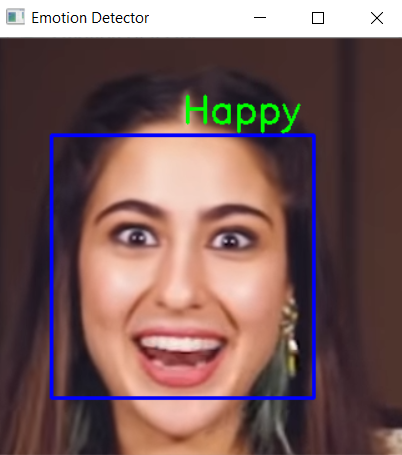

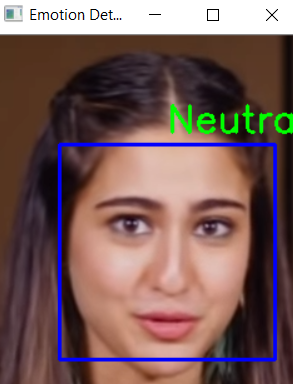

###  Testing on  webcam

In [27]:
face_classifier = cv2.CascadeClassifier('Haarcascades/haarcascade_frontalface_default.xml')

def face_detector(img):
    # Convert image to grayscale
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    faces = face_classifier.detectMultiScale(gray, 1.3, 5)
    if faces is ():
        return (0,0,0,0), np.zeros((48,48), np.uint8), img
    
    for (x,y,w,h) in faces:
        cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)
        roi_gray = gray[y:y+h, x:x+w]

    try:
        roi_gray = cv2.resize(roi_gray, (48, 48), interpolation = cv2.INTER_AREA)
    except:
        return (x,w,y,h), np.zeros((48,48), np.uint8), img
    return (x,w,y,h), roi_gray, img

cap = cv2.VideoCapture(0)

while True:

    ret, frame = cap.read()
    rect, face, image = face_detector(frame)
    if np.sum([face]) != 0.0:
        roi = face.astype("float") / 255.0
        roi = img_to_array(roi)
        roi = np.expand_dims(roi, axis=0)

        # make a prediction on the ROI, then lookup the class
        preds = classifier.predict(roi)[0]
        label = class_labels[preds.argmax()]  
        label_position = (rect[0] + int((rect[1]/2)), rect[2] + 25)
        cv2.putText(image, label, label_position , cv2.FONT_HERSHEY_SIMPLEX,2, (0,255,0), 3)
    else:
        cv2.putText(image, "No Face Found", (20, 60) , cv2.FONT_HERSHEY_SIMPLEX,2, (0,255,0), 3)
        
    cv2.imshow('All', image)
    if cv2.waitKey(1) == 13: #13 is the Enter Key
        break
        
cap.release()
cv2.destroyAllWindows()      

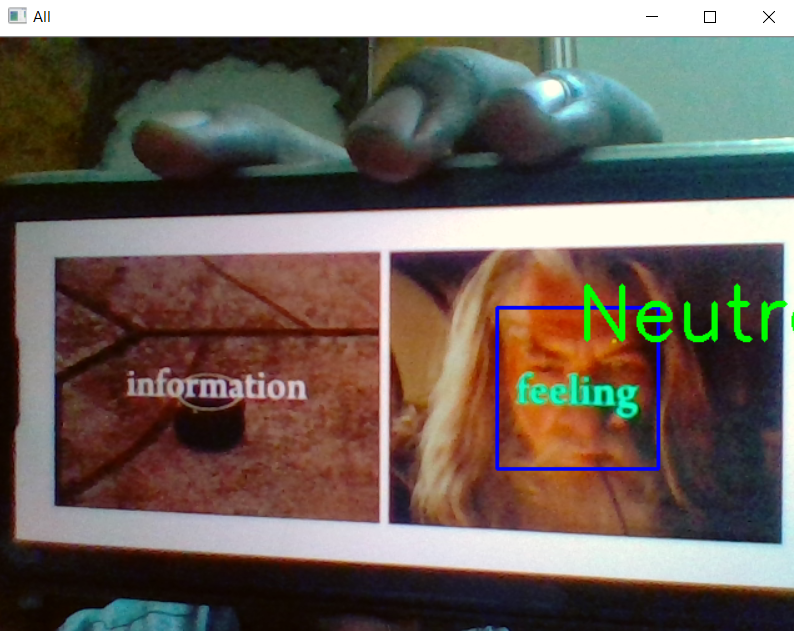

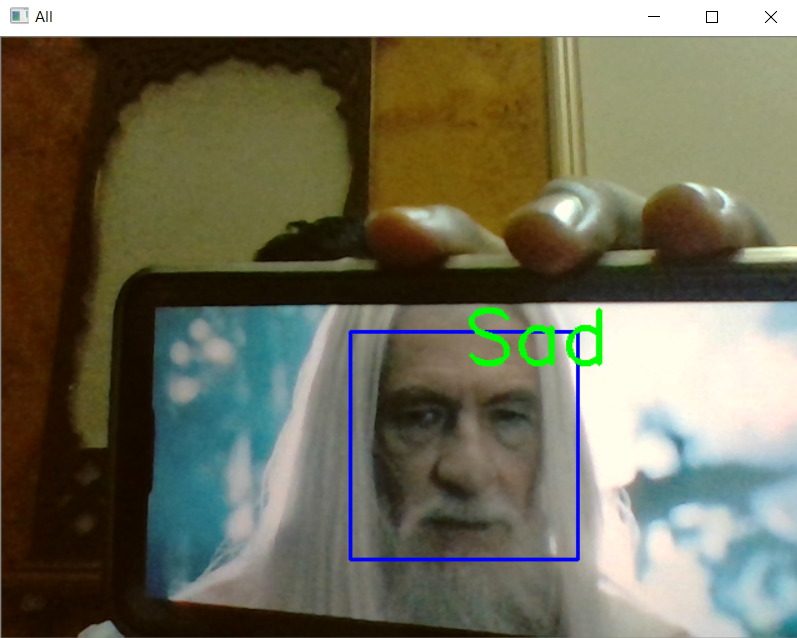

In [28]:
cap.release()
cv2.destroyAllWindows()      